# Naïve Bayes - Multinomial

A machine learning method you can use to predict the likelihood that an event will occur given previous data (conditional propability).

Assumptions: Predictors are independent of each other, a priori assumption (past conditions apply to present or future). 

Data: corpus data with fake news and real news available at: https://www.kaggle.com/competitions/fake-news/data?select=train.csv

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import sklearn

from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Import and explore data

In [2]:
path = 'C:/Users/Katia/Documents/Machine learning/fake-news'
os.chdir(path)

df = pd.read_csv('train.csv', sep=',')

In [3]:
df.head(20)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [4]:
df.shape

(20800, 5)

In [5]:
# Explore the number of unique values

for col in df.columns:
    print('{}: {} unique values'.format(col, df[col].nunique()))

id: 20800 unique values
title: 19803 unique values
author: 4201 unique values
text: 20386 unique values
label: 2 unique values


In [6]:
# Get NAs
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
# drop raws without text

df = df.dropna(subset=['text'])
df.isnull().sum()

id           0
title      558
author    1918
text         0
label        0
dtype: int64

In [8]:
# replace the null values with empty string
df = df.fillna('')
df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

## Process texts

In [3]:
# import libraries for text processing
import string
string.punctuation
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\katia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Clean, tokenize, and apply stemmer to text

ps = nltk.PorterStemmer()

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    # Because the file has other languages, narrow to alphabetic tokens
    tokens = [token for token in tokens if re.match('^([a-zA-Z]+|\d+|\W)$', token)]
    text = " ".join([ps.stem(word) for word in tokens if word not in stop_words])
    return text

df['clean_text_stemmed'] = df['text'].apply(lambda x: clean_text(x))
df.head()

,id,title,author,text,label,clean_text,clean_text_stemmed
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide even see comey letter jason cha...,hous dem aid even see comey letter jason chaff...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,ever get feeling life circle roundabout rather...,ever get feel life circl roundabout rather hea...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired october 29 2016 tension ...,truth might get fire octob 29 2016 tension int...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,video 15 civilian killed single u airstrike id...,video 15 civilian kill singl us airstrik ident...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six year prison ...,print iranian woman sentenc six year prison ir...


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# Reduce dataframe because of memory issues (50% in this case)
df2 = df.sample(frac=0.5)

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df2['clean_text_stemmed'])
print(X_counts.shape)
print(count_vect.get_feature_names())

(10380, 86706)
['00', '000', '0000', '0000035', '000025', '00011', '0005', '0009', '001', '0012', '0015', '0021', '0025', '0028', '003', '0031', '0038', '004', '0041', '0042', '0043', '0044', '0045', '0047', '0048', '0049', '005', '0050', '0054', '0055', '0056', '0059', '006', '007', '01', '010', '0100', '0103', '0105', '0108', '011116', '01112016', '011209', '0115', '012', '0121', '0125', '0127', '013107', '0132', '0133', '0134', '013705', '0143', '0144', '0148', '015', '0150', '0152', '0153', '0154', '015503', '0156', '016', '017', '018', '019', '02', '0200', '02032016', '0206', '0209', '021', '021116', '02112016', '0214', '0218', '022', '022006', '022016', '0222', '0229', '0230', '024', '0241', '0243', '0244', '0248', '025', '0250', '0254', '0255', '0258', '0259', '026', '027', '02863', '0292', '03', '0301', '0303', '0305', '0306', '0307', '0308', '031', '0310', '0311', '031116', '03112016', '0313', '032016', '0322', '034', '0345', '0346', '0349', '035', '0354', '0359', '036', '039'

In [17]:
# Create term-document matrix

X_array = pd.DataFrame(X_counts.toarray())
X_array.columns = count_vect.get_feature_names()
X_array

,00,000,0000,0000035,000025,00011,0005,0009,001,0012,...,zwischenlagern,zwischenzeitlich,zwo,zwoll,zyaira,zygankow,zylinderkopfdichtung,zymon,zyuganov,zzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10376,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10377,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10378,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Build model

In [18]:
# Separate dependent and independent variables

X = X_array
y = df2['label']

In [19]:
# Split data into training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2)

In [20]:
# Train model

MultiNB = MultinomialNB()
model = MultiNB.fit(X_train, y_train)
print(accuracy_score(y_train, MultiNB.predict(X_train)))

0.9426782273603083


In [21]:
# Test model

y_pred = MultiNB.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9132947976878613


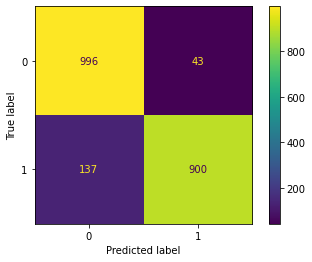

In [22]:
# Build confusion matrix

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)


In [23]:
# Get the words that mostly impacted the model

real_class_prob_sorted = MultiNB.feature_log_prob_[0, :].argsort()[::-1]
fake_class_prob_sorted = MultiNB.feature_log_prob_[1, :].argsort()[::-1]

print("Real class: ")
print(np.take(count_vect.get_feature_names(), real_class_prob_sorted[:100]))
print("Fake class: ")
print(np.take(count_vect.get_feature_names(), fake_class_prob_sorted[:100]))

Real class: 
['mr' 'said' 'trump' 'one' 'state' 'would' 'year' 'peopl' 'like' 'new'
 'presid' 'time' 'also' 'say' 'go' 'could' 'american' 'report' 'make'
 'work' 'even' 'mani' 'last' 'ms' 'call' 'two' 'nation' 'unit' 'use'
 'first' 'day' 'get' 'countri' 'hous' 'govern' 'includ' 'want' 'offici'
 'news' 'republican' 'take' 'offic' 'clinton' 'compani' 'show' 'think'
 'way' 'polit' 'back' 'group' 'campaign' 'made' 'support' 'week' 'obama'
 'come' 'right' 'citi' 'white' 'know' 'may' 'law' 'democrat' 'help'
 'world' 'parti' 'percent' 'much' 'million' 'told' 'look' 'still' 'ask'
 'polic' 'see' 'live' 'chang' 'elect' 'case' 'need' 'public' 'ad' 'part'
 'former' 'month' 'york' 'attack' 'famili' 'accord' 'administr' 'tri'
 'plan' 'follow' 'gener' 'secur' 'recent' 'thing' 'twitter' 'sinc'
 'member']
Fake class: 
['us' 'clinton' 'trump' 'one' 'peopl' 'state' 'would' 'hillari' 'like'
 'time' 'said' 'elect' 'new' 'year' 'american' 'also' 'use' 'world' 'even'
 'go' 'presid' 'govern' 'war' 'say' 'make

Even though there is a lof of overlap between both classes, the fake class includes words such as "russia", "war", "chang", "syria", "military", or words related to topics that may be more sensationalist. Other words such as "Hillary" and "email" may also suggest an explotation of the Hillary e-mail scandal in fake news.